In [2]:
import polars as pl
import json
import shap
import numpy as np
from great_tables import GT, md, html

from catboost import CatBoostRegressor,CatBoostClassifier, Pool

import plotly.graph_objects as go

from utils.utils import define_categorical_columns, define_continous_columns
from utils.modelling_utils import assign_split, create_modelling_data

In [3]:
frequency = pl.read_parquet('./processed-data/frequency_set.parquet')

In [4]:
with open('./config/frequency_config.json', 'r') as f:
    config = json.load(f)

In [5]:
features = config.get('features')

In [6]:
categorical_features = define_categorical_columns(frequency, features)
continous_features = define_continous_columns(features, categorical_features)

In [7]:
target = config.get('target')
exposure = config.get('exposure')
split = config.get('split')

In [8]:
frequency = assign_split(frequency, split)

In [9]:
def create_modelling_data(data, features, group_field, group, target, exposure = None):
    """
    Create modelling data by filtering the DataFrame based on the 'Group' column."
    """
    filtered_data = (
        data
        .filter(pl.col(group_field) == group)
    )

    train_X = (
        filtered_data
        .select(features)
        .to_pandas()
    )

    train_y = (
        filtered_data
        .select(target)
        .to_numpy()
        .ravel()
    )

    if exposure is not None:
        train_exposure = (
            filtered_data
            .with_columns(log_exposure=pl.col(exposure).log())
            .select('log_exposure')
            .to_numpy()
            .ravel()
        )

        return filtered_data, train_X, train_y, train_exposure

    return filtered_data, train_X, train_y



train, X_train, y_train, log_exposure_train = create_modelling_data(frequency, features, 'Group', 'Train', target, exposure)
test, X_test, y_test, log_exposure_test = create_modelling_data(frequency, features, 'Group', 'Test', target, exposure)
holdout, X_holdout, y_holdout, log_exposure_holdout = create_modelling_data(frequency, features, 'Group', 'Holdout', target, exposure)

train_pool = Pool(X_train, label=y_train, cat_features=categorical_features, baseline = log_exposure_train)
test_pool = Pool(X_test, label=y_test, cat_features=categorical_features, baseline = log_exposure_test)
holdout_pool = Pool(X_holdout, label=y_holdout, cat_features=categorical_features, baseline = log_exposure_holdout)



In [10]:
# CatBoost equivalent parameters
params = {
    'loss_function': 'Poisson',
    'learning_rate': 0.1,
    'depth': 3,
    'l2_leaf_reg': 2,
    'random_strength': 2,
    'bagging_temperature': 1,
    'verbose': 0
}

num_round = 20000

# Train
FrequencyModel = CatBoostRegressor(**params)
FrequencyModel.fit(train_pool, eval_set=[test_pool], early_stopping_rounds=10)

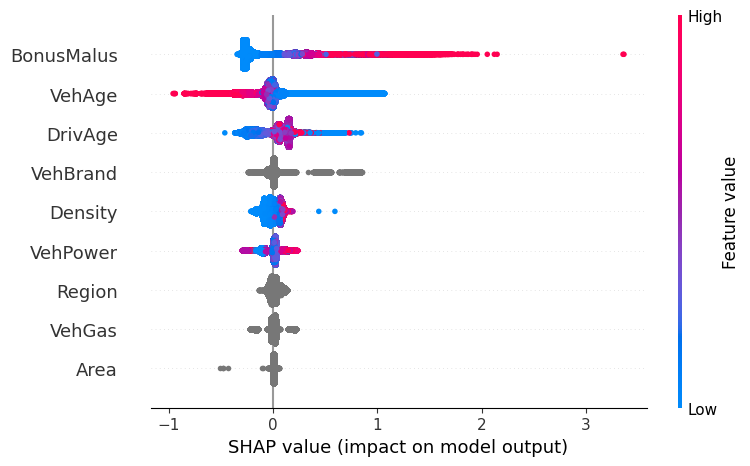

In [11]:
explainer = shap.TreeExplainer(FrequencyModel)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

In [12]:
catboost_predictions = FrequencyModel.predict(holdout_pool)

In [13]:
catboost_predictions

array([0.04598017, 0.01101742, 0.04826123, ..., 0.05064222, 0.16558987,
       0.0350493 ])

In [22]:
catboost_predictions = FrequencyModel.predict(holdout_pool)
holdout = (
    holdout.with_columns(ClaimCountPrediction = pl.Series(catboost_predictions))
)

In [23]:
with open('./config/continous_feature_visuals.json', 'r') as f:
    continous_feature_config = json.load(f)

In [36]:
def band_continous(
        df, 
        feature, 
        lower_bound, 
        upper_bound, 
        step_size
    ):
    """
    Band the continuous feature into discrete intervals.

    Args:
        df (pl.DataFrame): The input DataFrame.
        feature (str): The name of the continuous feature to be banded.
        lower_bound (float): The lower bound of the feature.
        upper_bound (float): The upper bound of the feature.
        step_size (float): The size of each band.

    Returns:
        pl.DataFrame: The DataFrame with the banded feature.
    """
    banded_data = (
        df
        .with_columns(
            pl.col(feature).clip(lower_bound = lower_bound, upper_bound = upper_bound).alias(feature)
        )
        .with_columns(
            ((pl.col(feature)/step_size).floor()*step_size).alias(feature)
        )
    )    

    return banded_data


def aggregate_frequency_df(
        df, 
        feature, 
        continous_feature_config, 
        claim_count = 'ClaimCount', 
        exposure = 'Exposure', 
        prediction = 'ClaimCountPrediction'
    ):

    """
    Aggregate frequency data by the specified feature.

    If continous, bands feature using provided configuration.

    Args:
        df (pl.DataFrame): The input DataFrame.
        feature (str): The name of the feature to aggregate by.
        continous_feature_config (dict): Configuration for continuous features.
        claim_count (str): The name of the claim count column.
        exposure (str): The name of the exposure column.
        prediction (str): The name of the prediction column.

    Returns:
        pl.DataFrame: The aggregated frequency DataFrame.
    """

    if feature in continous_feature_config:
        lower_bound = continous_feature_config.get(feature).get('min')
        upper_bound = continous_feature_config.get(feature).get('max')
        step_size = continous_feature_config.get(feature).get('step')

        df = band_continous(df, feature, lower_bound, upper_bound, step_size)

    aggregated_df = (
        df
        .group_by(feature)
            .agg(
                pl.col(exposure).sum(), 
                pl.col(claim_count).sum(), 
                pl.col(prediction).sum()
            )
        .with_columns(Frequency = pl.col(claim_count) / pl.col(exposure))
        .with_columns(FrequencyPrediction = pl.col(prediction) / pl.col(exposure))
        .sort(feature)
    )

    return aggregated_df


def create_frequency_table(
        df, 
        feature, 
        frequency = 'Frequency', 
        exposure = 'Exposure', 
        prediction = 'FrequencyPrediction', 
        experiment = 'Not Logged'
    ):

    """
    Creates a frequency table for the specified feature.

    Args:
        df (pl.DataFrame): The input DataFrame.
        feature (str): The name of the feature to create a frequency table for.
        frequency (str): The name of the frequency column.
        exposure (str): The name of the exposure column.
        prediction (str): The name of the prediction column.
        experiment (str): The name of the model experiment.

    Returns:
        pl.DataFrame: The created frequency table.
    """
    return (
        GT(df)
        .tab_header(
            title=f'Frequency - Actual vs Predicted - {feature}',
        )
        .tab_stub(rowname_col=feature)
        .tab_source_note(source_note=f'Trained on experiment: {experiment}')
        .tab_stubhead(label=feature)
        .fmt_integer(columns=exposure)
        .fmt_percent(columns=[frequency, prediction], decimals=1)
        .data_color(
            columns=[frequency, prediction],
            palette=["#63BE7B", "#FFEB84", "#F8696B"]
        )
        .cols_move(columns=prediction, after=frequency)
    )

def save_table_to_html(table, path):

    html_str = table.as_raw_html()
    with open(path, 'w', encoding='utf-8') as f:
        f.write(html_str)



def plot_aggregated_data(visual_data: pl.DataFrame, feature: str, target: str, prediction: str, exposure: str) -> None:

    fig = go.Figure()

    # Bar: Exposure
    fig.add_trace(go.Bar(
        x=visual_data[feature],
        y=visual_data[exposure],
        name=exposure,
        marker_color='lightskyblue',
        yaxis='y1'
    ))

    # Line: ClaimCount
    fig.add_trace(go.Scatter(
        x=visual_data[feature],
        y=visual_data[target],
        name=target,
        mode='lines+markers',
        line=dict(color='firebrick'),
        yaxis='y2'
    ))

    # Line: gbm_predictions
    fig.add_trace(go.Scatter(
        x=visual_data[feature],
        y=visual_data[prediction],
        name="Frequency Predictions",
        mode='lines+markers',
        line=dict(color='green', dash='dot'),
        yaxis='y2'
    ))

    # Layout with dual y-axes
    fig.update_layout(
        title=f"Frequency - Actuals vs Prediction - {feature}",
        xaxis=dict(title=feature),
        yaxis=dict(
            title=exposure,
            side="left",
            showgrid=False
        ),
        yaxis2=dict(
            title="Frequency",
            overlaying="y",
            side="right"
        ),
        barmode='group',
        legend=dict(x=0.01, y=0.99)
    )

    fig.write_html(f"./frequency-chart-{feature}.html")

    return fig

In [37]:
holdout

IDpol,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,Group,Exposure,ClaimCount,FrequencyPrediction,ClaimCountPrediction
i64,f64,f64,f64,f64,str,str,str,f64,str,str,f64,i32,f64,f64
2102858,7.0,14.0,20.0,100.0,"""B1""","""Regular""","""D""",1329.0,"""Ile-de-France""","""Holdout""",0.14,0,0.04598,0.04598
6114173,11.0,1.0,42.0,77.0,"""B12""","""Diesel""","""D""",1232.0,"""Provence-Alpes-Cotes-D'Azur""","""Holdout""",0.04,0,0.011017,0.011017
5096166,9.0,6.0,43.0,50.0,"""B12""","""Diesel""","""C""",373.0,"""Languedoc-Roussillon""","""Holdout""",0.61,0,0.048261,0.048261
3239647,7.0,4.0,38.0,50.0,"""B1""","""Regular""","""E""",2715.0,"""Centre""","""Holdout""",0.24,0,0.016899,0.016899
74318,5.0,16.0,39.0,125.0,"""B1""","""Regular""","""D""",1313.0,"""Centre""","""Holdout""",0.35,0,0.134226,0.134226
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
145561,7.0,18.0,38.0,50.0,"""B4""","""Regular""","""E""",3628.0,"""Rhone-Alpes""","""Holdout""",0.28,0,0.012235,0.012235
5105850,8.0,0.0,35.0,50.0,"""B12""","""Diesel""","""C""",241.0,"""Rhone-Alpes""","""Holdout""",0.12,0,0.017384,0.017384
1023454,4.0,13.0,41.0,50.0,"""B5""","""Diesel""","""B""",64.0,"""Centre""","""Holdout""",0.99,0,0.050642,0.050642


In [38]:
feature = 'Area'

aggregated_data = aggregate_frequency_df(holdout, feature, continous_feature_config)
frequency_table = create_frequency_table(aggregated_data, feature = feature)
save_table_to_html(frequency_table, path=f'frequency-table-{feature}.html')
frequency_table

GT(_tbl_data=shape: (6, 6)
┌──────┬──────────────┬────────────┬──────────────────────┬───────────┬─────────────────────┐
│ Area ┆ Exposure     ┆ ClaimCount ┆ ClaimCountPrediction ┆ Frequency ┆ FrequencyPrediction │
│ ---  ┆ ---          ┆ ---        ┆ ---                  ┆ ---       ┆ ---                 │
│ str  ┆ f64          ┆ i32        ┆ f64                  ┆ f64       ┆ f64                 │
╞══════╪══════════════╪════════════╪══════════════════════╪═══════════╪═════════════════════╡
│ A    ┆ 12431.75503  ┆ 978        ┆ 999.910921           ┆ 0.07867   ┆ 0.080432            │
│ B    ┆ 8571.61018   ┆ 728        ┆ 741.720332           ┆ 0.084932  ┆ 0.086532            │
│ C    ┆ 21035.635869 ┆ 1931       ┆ 1989.154183          ┆ 0.091797  ┆ 0.094561            │
│ D    ┆ 15435.785096 ┆ 1587       ┆ 1650.587332          ┆ 0.102813  ┆ 0.106933            │
│ E    ┆ 12700.506092 ┆ 1601       ┆ 1518.623835          ┆ 0.126058  ┆ 0.119572            │
│ F    ┆ 1621.628906  ┆ 251        ┆ 223.271308           ┆ 0.154783  ┆ 0.137683            │
└──────┴──────────────┴────────────┴──────────────────────┴───────────┴─────────────────────┘, _body=<great_tables._gt_data.Body object at 0x000001FAA9BE4470>, _boxhead=Boxhead([ColInfo(var='Area', type=<ColInfoTypeEnum.stub: 2>, column_label='Area', column_align='left', column_width=None), ColInfo(var='Exposure', type=<ColInfoTypeEnum.default: 1>, column_label='Exposure', column_align='right', column_width=None), ColInfo(var='ClaimCount', type=<ColInfoTypeEnum.default: 1>, column_label='ClaimCount', column_align='right', column_width=None), ColInfo(var='ClaimCountPrediction', type=<ColInfoTypeEnum.default: 1>, column_label='ClaimCountPrediction', column_align='right', column_width=None), ColInfo(var='Frequency', type=<ColInfoTypeEnum.default: 1>, column_label='Frequency', column_align='right', column_width=None), ColInfo(var='FrequencyPrediction', type=<ColInfoTypeEnum.default: 1>, column_label='FrequencyPrediction', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001FAA9BE7410>, _spanners=Spanners([]), _heading=Heading(title='Frequency - Actual vs Predicted - Area', subtitle=None, preheader=None), _stubhead='Area', _source_notes=['Trained on experiment: Not Logged'], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Frequency', rows=[0], mask=None), grpname=None, colname='Frequency', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#63be7b')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[1], mask=None), grpname=None, colname='Frequency', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#7dc57c')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[2], mask=None), grpname=None, colname='Frequency', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#99ce7e')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[3], mask=None), grpname=None, colname='Frequency', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#c6db81')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[4], mask=None), grpname=None, colname='Frequency', rownum=4, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fdcb7e')]), St

In [39]:
plot_aggregated_data(visual_data = aggregated_data, 
                        feature = feature, 
                        target = 'Frequency', 
                        prediction = 'FrequencyPrediction',
                        exposure = 'Exposure')

In [ ]:
feature = 'DrivAge'

aggregated_data = aggregate_frequency_df(holdout, feature, continous_feature_config)
frequency_table = create_frequency_table(aggregated_data, feature = feature)
save_table_to_html(frequency_table, path=f'frequency-table-{feature}.html')
frequency_table

GT(_tbl_data=shape: (13, 5)
┌─────────┬─────────────┬────────────┬─────────────────────┬───────────┐
│ DrivAge ┆ Exposure    ┆ ClaimCount ┆ FrequencyPrediction ┆ Frequency │
│ ---     ┆ ---         ┆ ---        ┆ ---                 ┆ ---       │
│ f64     ┆ f64         ┆ i32        ┆ f64                 ┆ f64       │
╞═════════╪═════════════╪════════════╪═════════════════════╪═══════════╡
│ 20.0    ┆ 2513.914099 ┆ 460        ┆ 0.189421            ┆ 0.182982  │
│ 25.0    ┆ 5110.920644 ┆ 538        ┆ 0.111561            ┆ 0.105265  │
│ 30.0    ┆ 7871.5223   ┆ 673        ┆ 0.090433            ┆ 0.085498  │
│ 35.0    ┆ 8770.742387 ┆ 789        ┆ 0.088169            ┆ 0.089958  │
│ 40.0    ┆ 8794.002106 ┆ 838        ┆ 0.096094            ┆ 0.095292  │
│ …       ┆ …           ┆ …          ┆ …                   ┆ …         │
│ 60.0    ┆ 4396.858498 ┆ 426        ┆ 0.090503            ┆ 0.096887  │
│ 65.0    ┆ 3578.601975 ┆ 322        ┆ 0.09335             ┆ 0.089979  │
│ 70.0    ┆ 2915.518685 ┆ 251        ┆ 0.096469            ┆ 0.086091  │
│ 75.0    ┆ 1921.934757 ┆ 204        ┆ 0.098482            ┆ 0.106143  │
│ 80.0    ┆ 1204.602025 ┆ 114        ┆ 0.098446            ┆ 0.094637  │
└─────────┴─────────────┴────────────┴─────────────────────┴───────────┘, _body=<great_tables._gt_data.Body object at 0x0000015901226AE0>, _boxhead=Boxhead([ColInfo(var='DrivAge', type=<ColInfoTypeEnum.stub: 2>, column_label='DrivAge', column_align='right', column_width=None), ColInfo(var='Exposure', type=<ColInfoTypeEnum.default: 1>, column_label='Exposure', column_align='right', column_width=None), ColInfo(var='ClaimCount', type=<ColInfoTypeEnum.default: 1>, column_label='ClaimCount', column_align='right', column_width=None), ColInfo(var='Frequency', type=<ColInfoTypeEnum.default: 1>, column_label='Frequency', column_align='right', column_width=None), ColInfo(var='FrequencyPrediction', type=<ColInfoTypeEnum.default: 1>, column_label='FrequencyPrediction', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001590124BA70>, _spanners=Spanners([]), _heading=Heading(title='Frequency - Actual vs Predicted - DrivAge', subtitle=None, preheader=None), _stubhead='DrivAge', _source_notes=['Trained on experiment: Not Logged'], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Frequency', rows=[0], mask=None), grpname=None, colname='Frequency', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f8696b')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[1], mask=None), grpname=None, colname='Frequency', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#a4d17f')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[2], mask=None), grpname=None, colname='Frequency', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#66bf7b')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[3], mask=None), grpname=None, colname='Frequency', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#74c37c')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[4], mask=None), grpname=None, colname='Frequency', rownum=4, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#85c87d')]), StyleInfo(locname=LocBody

In [ ]:
plot_aggregated_data(visual_data = aggregated_data, 
                        feature = feature, 
                        target = 'Frequency', 
                        prediction = 'FrequencyPrediction',
                        exposure = 'Exposure')

In [20]:
from reportlab.platypus import SimpleDocTemplate, Image, Spacer, Paragraph
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet
import plotly.express as px
import io

In [21]:
features = [
        "VehPower",
        "VehAge",
        "DrivAge",
        "BonusMalus",
        "VehBrand",
        "VehGas",
        "Area",
        "Density",
        "Region"
    ]

In [ ]:
from reportlab.platypus import SimpleDocTemplate, Image, Spacer, Paragraph, PageBreak
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet
import io
import matplotlib.pyplot as plt

# Page and margin configuration
PAGE_WIDTH, PAGE_HEIGHT = letter
TOP_MARGIN = 72
BOTTOM_MARGIN = 72
LEFT_MARGIN = 72
RIGHT_MARGIN = 72
AVAILABLE_HEIGHT = PAGE_HEIGHT - TOP_MARGIN - BOTTOM_MARGIN

def render_gt_latex_as_image(gt_obj, width=6, height=2):
    """
    Render a GT object as LaTeX to a PNG image in memory.
    """
    latex_str = gt_obj.as_latex()
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.axis('off')
    
    # Render LaTeX string in figure
    ax.text(0, 1, latex_str, fontsize=10, va='top', family='monospace')
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    return buf

def generate_pdf_report(features, output_file="report.pdf"):
    """
    Generates a PDF report from a list of features.
    Each feature gets its own Plotly chart and GT table (as LaTeX) on a new page.
    Chart and table scale automatically to fit the page.
    """
    doc = SimpleDocTemplate(
        output_file, pagesize=letter,
        topMargin=TOP_MARGIN, bottomMargin=BOTTOM_MARGIN,
        leftMargin=LEFT_MARGIN, rightMargin=RIGHT_MARGIN
    )
    elements = []
    styles = getSampleStyleSheet()
    
    for i, feature in enumerate(features):
        if i > 0:
            elements.append(PageBreak())
        
        # Heading
        elements.append(Paragraph(f"Report for: {feature}", styles['Heading2']))
        elements.append(Spacer(1, 12))
        
        # Heights for chart and table
        heading_height = 24
        spacer_height = 12 + 12 + 24
        max_content_height = AVAILABLE_HEIGHT - heading_height - spacer_height
        chart_height = max_content_height * 0.6
        table_height = max_content_height * 0.4
        image_width = PAGE_WIDTH - LEFT_MARGIN - RIGHT_MARGIN
        
        # --- Plotly chart ---
        aggregated_data = aggregate_frequency_df(holdout, feature, continous_feature_config)
        fig_chart = plot_aggregated_data(
            visual_data=aggregated_data,
            feature=feature,
            target='Frequency',
            prediction='FrequencyPrediction',
            exposure='Exposure'
        )
        buf_chart = io.BytesIO()
        fig_chart.write_image(buf_chart, format="png")
        buf_chart.seek(0)
        elements.append(Image(buf_chart, width=image_width, height=chart_height))
        elements.append(Spacer(1, 12))
        
        # --- GT table via LaTeX ---
        gt_table = create_frequency_table(aggregated_data, feature = feature)
        buf_table = render_gt_latex_as_image(gt_table, width=image_width/72, height=table_height/72)
        elements.append(Image(buf_table, width=image_width, height=table_height))
        elements.append(Spacer(1, 24))
    
    # Build PDF
    doc.build(elements)
    print(f"PDF report saved to {output_file}")


In [40]:
generate_pdf_report(features, output_file="report.pdf")

e:\python-for-pricing-course\.venv\Lib\site-packages\great_tables\_utils_render_latex.py:30: UserWarning:

Styles are not yet supported in LaTeX output.



NotImplementedError: The table stub (row names and/or row groups) are not yet supported in LaTeX output.